# Cobinding PiPeline: pre processing & analysis

In [390]:
import os
import pandas as pd
import sys
sys.path.insert(0, '../..')
import itertools
from scipy import stats

import numpy as np

from JKBio.epigenetics import chipseq as chip
from JKBio.utils import helper
from JKBio.utils import plot
from JKBio.google import gcp
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
project="Cobinding_ChIP"
version="v3"

## processing using Nextflow

In [78]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/paired_end/*MV411* # all other cell lines don't have the right INPUT
fastq

['gs://amlproject/Chip/fastqs/paired_end/mp299-MV411-CEBPA-r3_S7_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp299-MV411-CEBPA-r3_S7_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp300-MV411-RUNX1-r3_S8_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp300-MV411-RUNX1-r3_S8_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp301-MV411-PU1-r2_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp301-MV411-PU1-r2_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp319-MV411-FLI1-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp319-MV411-FLI1-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp320-MV411-ZEB2-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp320-MV411-ZEB2-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp321-MV411-GFI1-r1_R1.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp321-MV411-GFI1-r1_R2.fastq.gz',
 'gs://amlproject/Chip/fastqs/paired_end/mp324-MV411-MEF2D-r1_R1.fastq.gz',
 'gs://aml

In [94]:
from gsheets import Sheets
# Here you might not need this line, otherwise you need to generate your json files from 
# https://pygsheets.readthedocs.io/en/stable/authorization.html
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()

In [80]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in helper.grouped(fastq,2):
    row = gsheet[gsheet.id==val[0].split('/')[-1].split('-')[0]]
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val[0])
    df['fastq_2'].append(val[1])
    if row['matching input name'].values[0] is not None:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_paired_end_design.csv',index=False)

In [97]:
fastq = ! gsutil ls gs://amlproject/Chip/fastqs/*.gz
fastq

['gs://amlproject/Chip/fastqs/db28-MV411-H3K18-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db29-MV411-AFF4-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db30-MV411-CDK9-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db31-MV411-PSER2-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db32-MV411-INPUT-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db33-MV411-INPUT-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db34-MV411-CEBPB-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db35-MV411-INPUT-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db36-MV411-INPUT-r4.fastq.gz',
 'gs://amlproject/Chip/fastqs/db37-MV411-WDR5_429A-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db38-MV411-WDR5_429A-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db39-MV411-WDR5_429A-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db40-MV411-WDR5_D9E1-r1.fastq.gz',
 'gs://amlproject/Chip/fastqs/db41-MV411-WDR5_D9E1-r2.fastq.gz',
 'gs://amlproject/Chip/fastqs/db42-MV411-WDR5_D9E1-r3.fastq.gz',
 'gs://amlproject/Chip/fastqs/db43-MV411-IGG-r1.fastq.gz',
 'gs

In [98]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] in ["IRF2BP2", "H3K27ac", "H3K36me3", "H3K27me3", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "H3K18", "BRD4"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_np.csv',index=False)

In [93]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in fastq:
    row = gsheet[gsheet.id==val.split('/')[-1].split('-')[0]]
    if row['protein'].values[0] not in ['INPUT',"IGG","IRF2BP2", "H3K27ac", "CEBPA", "H3K36me3", "PU1", "H3K27me3", "SMC1", "MED1", "H3K79me2", "H3K4me3", "H3K4me1", "H3K36me2", "H3K9ac", "CEBPB", "H3K18", "BRD4", "WDR5"]:
        continue
    df['group'].append(row['name'].values[0].split('-r')[0])
    df['replicate'].append(1)
    df['fastq_1'].append(val)
    df['fastq_2'].append("")
    if row['matching input name'].values[0] is not None and row['matching input name'].values[0] is not np.nan:
        df['antibody'].append(row['protein'].values[0])
        cont = gsheet[gsheet.id==row['matching input name'].values[0]]
        df['control'].append(cont['name'].values[0].split('-r')[0])
    else:
        df['antibody'].append("")
        df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_single_end_design_bp.csv',index=False)

## Pipeline

![](images/gcpjup.png)


- Raw read QC (FastQC)
- Adapter trimming (Trim Galore!)
- Alignment (BWA)
- Mark duplicates (picard)
- Merge alignments from multiple libraries of the same sample (picard)
- Re-mark duplicates (picard)
- Filtering to remove: blacklisted regions, duplicates, primary alignments,unmapped,multiple locations, containing >  4 mismatches, insert size > 2kb, map to different chromosomes 
- Alignment-level QC and estimation of library complexity (picard, Preseq)
- Create normalised bigWig files scaled to 1 million mapped reads (BEDTools, bedGraphToBigWig)
- Generate gene-body meta-profile from bigWig files (deepTools)
- Calculate genome-wide IP enrichment relative to control (deepTools)
- Calculate strand cross-correlation peak and ChIP-seq quality measures including NSC and RSC (phantompeakqualtools)
- Call broad/narrow peaks (MACS2)
- Annotate peaks relative to gene features (HOMER)
- Create consensus peakset across all samples and create tabular file to aid in the filtering of the data (BEDTools)
- Count reads in consensus peaks (featureCounts)

![](images/nfcore.png)


## about
0. you need to have a google project set up with a billing account
1. you need to activte your APIs this way: https://cloud.google.com/life-sciences/docs/tutorials/nextflow?hl=fr
2. nextflow needs to be installed with this installation command `export NXF_MODE=google && curl https://get.nextflow.io | bash`
3. you will export the credentials to your google account (see google cloud oauth) `export GOOGLE_APPLICATION_CREDENTIALS=aml-chipseq-rnaseq-9dcbe47182cf.json`
4. look more about the chipseq pipeline here: https://nf-co.re/chipseq
5. now you can run the code as below (to run it locally, use `-profile docker`)
6. to run it on google cloud make a conf file with your google paymnt project id: `echo "google.project = 'YOUR_GOOGLE_PROJECT_ID'" >> my.config` and run the pipeline using: `-profile jkcloud --custom_local_config my.config`
7. to run it elsewhere, look at nf-core's documentation

In [ ]:
-profile #my profile for the cloud (to edit for your account) jkcloud
-w #where the withinput will be stored
--outdir #specify aa bucket+folderr where the results will be
--tracedir #you need to specify a local place for that
--custom_local_config custom_local.config #yoour custtom config

In [66]:
#process chips 
! ../../nextflow run jkobject/chipseq --paired_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_paired_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingp --outdir gs://workamlproject/cobindingpres --tracedir ../nextflow/cobindingp/ --narrow_peak

.nextflow/history.lock (Permission denied)


In [ ]:
#calling narrow peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindings --outdir gs://workamlproject/cobindingsres --tracedir ../nextflow/cobindings/ --narrow_peak

In [ ]:
#calling broad peak proteins in single end
! ../../nextflow run jkobject/chipseq --single_end --seq_center 'multiple' --email 'jkobject@gmail.com' --input ../nextflow/$project_single_end_broad_design.csv --genome 'GRCh38' --max_cpus 16 -profile 'jkcloud' -w gs://workamlproject/cobindingsb --outdir gs://workamlproject/cobindingsbres --tracedir ../nextflow/cobindingsb/

## Gathering data

we are using a folder outside our repository as there is too many huge files.

In [105]:
! gsutil -m cp -r gs://workamlproject/cobindingpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_pe_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [ ]:
! gsutil -m cp -r gs://workamlproject/cobindingsbpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_bp.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/broadPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [ ]:
! gsutil -m cp -r gs://workamlproject/cobindingsnpres/* gs://amlproject/Chip/res/
#rename files: doing it once for each copy _pe, _se_bp, _se_np
helper.parrun(['gsutil mv '+i+' '+i.split('.')[0]+'_se_np.'+i.split('.')[1] for i in ["gs://amlproject/Chip/res/multiqc/narrowPeak/multiqc_report.html",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_files.txt",
"gs://amlproject/Chip/res/igv/narrowPeak/igv_session.xml",
"gs://amlproject/Chip/res/pipeline_info/design_controls.csv",
"gs://amlproject/Chip/res/pipeline_info/design_reads.csv",
"gs://amlproject/Chip/res/pipeline_info/results_description.html",
"gs://amlproject/Chip/res/pipeline_info/software_versions.csv"]],cores=8)

In [ ]:
! gsutil mv gs://amlproject/Chip/res/multiqc/broadPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/multiqc/narrowPeak/* gs://amlproject/Chip/res/multiqc/
! gsutil mv gs://amlproject/Chip/res/igv/narrowPeak/* gs://amlproject/Chip/res/igv/
! gsutil mv gs://amlproject/Chip/res/igv/broadPeak/* gs://amlproject/Chip/res/igv/

In [ ]:
!mkdir ../../data/$project && mkdir ../../data/$project/peaks/ && mkdir ../../data/$project/wigs/
# getting the data for cobinding
!gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/macs/*Peak/*Peak ../../data/$project/peaks
!gsutil -m cp -r gs://amlproject/Chip/res/bwa/mergedLibrary/bigwig/ ../../data/$project/wigs
# ading the chips from diffBinding DMSO
for val in ['chipseq_MEF2D_degraded','chipseq_IRF8_degraded']:
    !gsutil -m cp -r gs://amlproject/Chip/$val/bwa/mergedLibrary/macs/*Peak/*DMSO*Peak ../../data/$project/peaks
    !gsutil -m cp -r gs://amlproject/Chip/$val/bwa/mergedLibrary/bigwig/*DMSO* ../../data/$project/wigs

In [ ]:
bw

In [ ]:
#renaming samples from differentiaal binding experiments
#files = ! ls ../../data/$project/MV411peak/*
bw = !ls ../../data/$project/wigs/bigwig/*.bigWig
rn = {
'MV411_IRF8_NT_DMSO-IRF8': 'mp901-MV411_IRF8_NT_DMSO-IRF8-r1',
'MV411_IRF8_NT_DMSO-MED1': 'mp903-MV411_IRF8_NT_DMSO-MED1-r1',
'MV411_IRF8_NT_DMSO-MEF2C': 'mp905-MV411_IRF8_NT_DMSO-MEF2C-r1',
'MV411_IRF8_NT_DMSO-MEF2D': 'mp907-MV411_IRF8_NT_DMSO-MEF2D-r1',
'MV411_IRF8_NT_DMSO-MYC': 'mp909-MV411_IRF8_NT_DMSO-MYC-r1',
'MV411_IRF8_NT_DMSO-POLII_total': 'mp911-MV411_IRF8_NT_DMSO-POLII_total-r1',
'MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D': 'mp881-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r3',
'MV411_MEF2D_NT_SC_63_DMSO-IFR8': 'mp883-MV411_MEF2D_NT_SC_63_DMSO-IRF8-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MED1': 'mp885-MV411_MEF2D_NT_SC_63_DMSO-MED1-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MEF2C': 'mp887-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r1',
'MV411_MEF2D_NT_SC_63_DMSO-MYC': 'mp889-MV411_MEF2D_NT_SC_63_DMSO-MYC-r1',
'MV411_MEF2D_NT_SC_63_DMSO-POLII': 'mp891-MV411_MEF2D_NT_SC_63_DMSO-POLII-r1', 
}
for i,v in rn.items():
    for val in bw:
        if i in val:
            n = val.replace(i,v)
            ! mv $val $n

In [ ]:
! mkdir ../../data/$project/MV411peak
! cp ../../data/$project/peaks/*MV411*.narrowPeak ../../data/$project/MV411peak/
! cp ../../data/$project/peaks/*MV411*.broadPeak ../../data/$project/MV411peak/

In [ ]:
#removing wrong peak calls (broad insteadd of narrow)
! rm ../../data/$project/MV411peak/mp577-MV411-SMC1_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp728-MV411_DMSO-CEBPA_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp112-MV411-CEBPA_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp115-MV411-PU1_R1_peaks.broadPeak
! rm ../../data/$project/MV411peak/mp428-MV411-PU1_R1_peaks.broadPeak

In [ ]:
bindings = chip.loadPeaks(peakfolder = '../../data/'+project+'/MV411peak/', isMacs=False,skiprows=0)

In [ ]:
peaks = !ls ../../data/$project/MV411peak/*.narrowPeak
broadpeaks = ! ls ../../data/$project/MV411peak/*.broadPeak
peaks = set([i.split('/')[-1].split('.')[0] for i in broadpeaks]) | set([i.split('/')[-1].split('.')[0] for i in peaks])
peaks

## preprocessing the data and renaming

In [723]:
bindings = bindings[bindings['name']!="ATAC_MV411.mRp.clN_peaks"]

In [730]:
## setting good namings and TFs
bindings.loc[bindings[bindings['name'] == 'mp919-MV411_MEF2D_NT_SC_63-FLAF_MEF2D_R1_peaks'].index,'name'] = 'mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D_R1_peaks'
bindings['replicate']= [i.split('-')[0] for i in bindings['name']]
bindings['tf'] = [i.split('-')[2].split('_R1')[0] for i in bindings['name']]
bindings['name'] = [i[:-9] for i in bindings['name']] 
bindings.loc[bindings[bindings['tf'].isin(['WDR5_429A','WDR5_D9E1'])].index,'tf'] = 'WDR5'
bindings.loc[bindings[bindings['tf']=="POLII_total"].index,'tf'] = 'POLII'
len(bindings),set(bindings['tf'])

(4647269,
 {'AFF4',
  'BRD4',
  'CDK13',
  'CDK9',
  'CEBPA',
  'CEBPB',
  'CTCF',
  'E2F3',
  'ELF2',
  'ETV6',
  'FLAG_GFI',
  'FLAG_IRF2BP2',
  'FLAG_MEF2C',
  'FLAG_MEF2D',
  'FLAG_PU1',
  'FLI1',
  'FOSL2',
  'FOXP1',
  'GATA2',
  'GFI1',
  'GSE1',
  'H3K18',
  'H3K27ac',
  'H3K27me3',
  'H3K36me2',
  'H3K36me3',
  'H3K4me1',
  'H3K4me3',
  'H3K79me2',
  'H3K9ac',
  'HEX',
  'HOXA9',
  'IKZF1',
  'IRF2BP2',
  'IRF8',
  'JUND',
  'LDB1',
  'LMO2',
  'LYL1',
  'MAX',
  'MED1',
  'MEF2C',
  'MEF2D',
  'MEIS1',
  'MLL_KTM2A',
  'MYB',
  'MYBL2',
  'MYC',
  'PLAGL2',
  'POLII',
  'PSER2',
  'PU1',
  'RARA',
  'RUNX1',
  'RUNX2',
  'RXRA',
  'SMC1',
  'SP1',
  'SREBP1',
  'STAT5B',
  'TFP4',
  'WDR5',
  'ZEB2',
  'ZFP281',
  'ZMYND8'})

In [731]:
bindings.to_csv('../results/'+project+'/large/'+version+'_all_bindings.bed.gz',sep='\t',index=False)

In [ ]:
bindings= pd.read_csv('../results/'+project+'/large/'+version+'_all_bindings.bed.gz',sep='\t',header=None, index_col=None,
                     names=["-log10pvalue","-log10qvalue", "chrom", "end", "foldchange", "name", "peak_number", "relative_summit_pos", "start", "replicate","tf"])

In [732]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()
gsheet

,id,cell line,replicate,protein,quality,paired_end,matching input name,processed,name,previous name,...,unique mapped reads(droso),scaling factor,Unnamed: 25,Total QC,folderNarrow,folderCompensated,folderQC,folderBroad,folder Bigwig,folder diffPeaks
0,mp100,U937,1,INPUT,NaN,n,NaN,Y,mp100-U937-INPUT-r1,NaN,...,NaN,NaN,NaN,https://storage.cloud.google.com/amlproject/Ch...,https://console.cloud.google.com/storage/brows...,NaN,https://console.cloud.google.com/storage/brows...,https://console.cloud.google.com/storage/brows...,https://console.cloud.google.com/storage/brows...,NaN
1,mp101,NOMO1,1,INPUT,NaN,n,NaN,Y,mp101-NOMO1-INPUT-r1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mp102,UT7,1,INPUT,NaN,n,NaN,Y,mp102-UT7-INPUT-r1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mp106,MV411,1,MYB,x,n,mp99,Y,mp106-MV411-MYB-r1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mp109,M6,1,CEBPA,x,n,mp98,Y,mp109-M6-CEBPA-r1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,mp916,MV411,1,E2F3,NaN,y,mp845,NaN,mp916-MV411-E2F3-r1,20201023_E2F3_MP8382_S41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,mp917,MV411,1,SREBP1,NaN,y,mp845,NaN,mp917-MV411-SREBP1-r1,20201023_SREBP1_MP8382_S42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,mp918,MV411_GFI_SC,1,FLAG_GFI,NaN,y,mp845,NaN,mp918-MV411_GFI_SC-FLAG_GFI-r1,20200903_1_MP8215_S101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
376,mp919,MV411_MEF2D_NT_SC_63,3,FLAG_MEF2D,NaN,y,mp845,NaN,mp919-MV411_MEF2D_NT_SC_63-FLAG_MEF2D-r3,20200903_2_MP8215_S102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bw = ! ls ../../data/$project/wigs/bigwig/*.bigWig
len(bw), bw

In [ ]:
# ONE off
for i in bw[2:]:
    a = gsheet[gsheet.id=='mp'+i.split('_')[2]].name.values[0]
    i = '../../data/bigwig/'+i
    a = '../../data/bigwig/'+a+'.mLb.clN.bigWig'
    ! mv $i $a
    print(a)

In [ ]:
replicates = chiphelper.findReplicates(folder='../data/seqs/results/bwa/', sep='_', namings='_R([0-9])',namepos=0)

## Visual inspection of the features and and look at QCs

### igv tracks
use `gs://amlproject/Chip/res/igv/igv_session_all.xml` as a session file from server in the https://igv.org/app

### multiQC
look at all files in this [bucket folder](https://console.cloud.google.com/storage/browser/amlproject/Chip/res/multiqc/)

### annotate bad quality chips: 

1. look at all replicates with a very low frip score (as noted by encode: <1%). 

2. look at all peaks tracks together and see for location of intense co binding. 
    - if we can discern peaks and if, for some reasons, some good peaks are not called by macs. 
    - if looks good and we can see a lot of peaks. 
    - if a lot of noise but seems consistent with replicates. 
    - if just seems to have very few peaks.


In [ ]:
#badquality samples: frip score below 1% or duplications > 40%
bad=["db29", "db30", "db31", "db32", "db34", "db37", "db38", "db40", "db41", "db42", "db43", "db44", "db45", "db47", "db49", "db52", "dp51", "mp115", "mp117", "mp118", "mp124", "mp125", "mp128", "mp129", "mp154", "mp156", "mp168", "mp171", "mp196", "mp27", "mp27", "mp33", "mp35", "mp358", "mp424", "mp425", "mp427", "mp428", "mp430", "mp431", "mp433", "mp565", "mp568", "mp569", "mp570", "mp575", "mp581", "mp589", "mp590", "mp601", "mp604", "mp607", "mp614", "mp623", "mp627", "mp631", "mp636", "mp638", "mp639", "mp640", "mp650", "mp690", "mp714", "mp715", "mp716", "mp717", "mp718", "mp724", "mp728", "mp739", "mp741", "mp742", "mp743", "mp745", "mp748", "mp750", "mp751", "mp770", "mp771", "mp773", "mp772", "mp774", "mp878", "mp321", "mp874", "mp324", "mp875", "mp879", "mp880", "mp913", "mp914", "mp915", "mp916", "mp917","mp887"]

## merging duplicates

This function takes as an input a bed-like df file. It should be a concatenation of 1 or many chip experiment with at least some with multiple replicates.

It will merge the replicate based on the following logic:

1. look at peak overlaps by merging everything as one peaks f within a defined window (default: )
2. take the -if possible, non bad quality- sample with the most peaks as the main peak
3. for every other peak:
    1. we compare them
        - if there is no minimum overlap and one is bad quality we drop it
        - if there is no minimum overlap and both are good quality we ask if we should try to continue or discard the TF entirely. 
        - if there is some minimum overlap amount, we continue
    2. we look in the main replicate's bigwig, if we can recover some peaks where we had data from the other replicate. we used a poisson distribution that we fit to the background and the peak location and compare them using a KL divergence metric. If it is above the threshold, we report the fold-change value and p_values
    3. we do the same for the other replicate's bigwig under the main replicate's peaks.
    4. when we merge the new peaks, we recompute the global pvalue of the peak and average its fold-change across all replicates
4. all peaks reported under the main replicate (including recovered ones) or present in more than 2 other replicates are used as the "peaks in the merged version".


In [ ]:
set(bindings.name)

In [ ]:
bindings = bindings[bindings.tf=="MEF2C"]

In [ ]:
%matplotlib inline
mergedpeak, tomergebam, remove, ratiosofunique = chip.mergeReplicatePeaks(bindings,         '../../data/'+project+'/wigs/bigwig/', markedasbad=bad, window=150, mincov=4, doPlot=True, minKL=10, cov={}, use='poisson', MINOVERLAP=0.25, lookeverywhere=True, only='', saveloc='../results/'+project+'/plots/'+version+'_retryMEF2C/')

In [817]:
mergedpeak #= mergedpeak[mergedpeak.columns[[2,9,3,5,6,4,0,1,7,10]]]

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,name,tf
0,chr1,10087,10317,0,5.914910,1.068010e+01,6.748430e+00,134,MEF2C,MEF2C
1,chr1,180760,181047,1,4.843950,1.076920e+01,6.833590e+00,134,MEF2C,MEF2C
2,chr1,183562,184551,2,3.851040,3.916524e+01,9.580449e+00,636,MEF2C,MEF2C
3,chr1,261731,262752,3,2.155440,3.927820e+00,1.561020e+00,1021,MEF2C,MEF2C
4,chr1,605257,605586,4,3.837510,5.112510e+00,2.433650e+00,329,MEF2C,MEF2C
...,...,...,...,...,...,...,...,...,...,...
28493,chrY,56715020,56715854,102322,14.657783,1.485973e+05,9.279942e+04,425,MEF2C,MEF2C
28494,chrY,56720710,56721183,102324,3.987447,5.592550e+02,1.071451e+02,370,MEF2C,MEF2C
28495,chrY,56751860,56752350,102327,2.314990,1.082143e+03,2.585016e+02,203,MEF2C,MEF2C
28496,chrY,56763271,56763586,102329,1.970413,2.576388e+06,2.256173e+06,215,MEF2C,MEF2C


In [740]:
tomergebam

[['mp299-MV411-CEBPA', 'mp72-MV411-CEBPA'],
 ['mp299-MV411-CEBPA', 'mp728-MV411_DMSO-CEBPA'],
 ['mp299-MV411-CEBPA', 'mp112-MV411-CEBPA'],
 ['mp583-MV411-ELF2', 'mp607-MV411-ELF2'],
 ['mp771-MV411-JUND', 'mp772-MV411-JUND'],
 ['mp773-MV411-HOXA9', 'mp774-MV411-HOXA9'],
 ['mp718-MV411-IRF2BP2', 'mp430-MV411-IRF2BP2'],
 ['mp718-MV411-IRF2BP2', 'mp431-MV411-IRF2BP2'],
 ['mp425-MV411-ETV6', 'mp569-MV411-ETV6'],
 ['mp70-MV411-H3K27ac', 'mp702-MV411_DMSO-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp734-MV411_DMSO-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp88-MV411-H3K27ac'],
 ['mp70-MV411-H3K27ac', 'mp136-MV411-H3K27ac'],
 ['db55-MV411-RUNX1', 'mp300-MV411-RUNX1'],
 ['db55-MV411-RUNX1', 'mp424-MV411-RUNX1'],
 ['db55-MV411-RUNX1', 'mp129-MV411-RUNX1'],
 ['mp767-MV411-FOXP1', 'mp768-MV411-FOXP1'],
 ['mp587-MV411-IKZF1', 'mp604-MV411-IKZF1'],
 ['db46-MV411-BRD4', 'db47-MV411-BRD4'],
 ['mp325-MV411-SP1', 'mp426-MV411-SP1'],
 ['mp325-MV411-SP1', 'mp118-MV411-SP1'],
 ['mp301-MV411-PU1', 'mp428-MV411-PU1'],
 [

In [738]:
# TFs that you might want to remove because of their quality
remove

['WDR5', 'GATA2', 'MEF2C']

## sorting and removing samples

In [739]:
rename = {'FLAG_GFI':'FLAG_GFI1', 'FLAG_PU1':'FLAG_SPI1', 'PU1':'SPI1', 'ZFP281':'ZNF281', 'TFP4':'TFAP4','SREBP1':'SREBF1'}
mergedpeak.tf = mergedpeak.tf.replace(rename)

In [742]:
#what tfs do we have in our set?
tfs = set(mergedpeak.tf)
tfs

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPA',
 'CEBPB',
 'CTCF',
 'E2F3',
 'ELF2',
 'ETV6',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_MEF2D',
 'FLAG_SPI1',
 'FLI1',
 'FOSL2',
 'FOXP1',
 'GATA2',
 'GFI1',
 'GSE1',
 'H3K18',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'HEX',
 'HOXA9',
 'IKZF1',
 'IRF2BP2',
 'IRF8',
 'JUND',
 'LDB1',
 'LMO2',
 'LYL1',
 'MAX',
 'MED1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MLL_KTM2A',
 'MYB',
 'MYBL2',
 'MYC',
 'PLAGL2',
 'POLII',
 'PSER2',
 'RARA',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SMC1',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'WDR5',
 'ZEB2',
 'ZMYND8',
 'ZNF281'}

In [741]:
mergedpeak.to_csv('../results/'+project+'/large/merged_replicates_'+version+'.csv.gz')

In [ ]:
bigwigs=os.listdir('../../data/bigwig/')
for val in bigwigs:
    for v in remove + toremove + ['scale','POLII','IGG','CTCF','INPUT']:
        if v in val:
            bigwigs.remove(val)
            break
bigwigs = ['data/bigwig/'+ i for i in bigwigs]

## Consensus set

In [970]:
window = 5
merging_version = "simpleMerge"

In [921]:
#getting the crcs
crc = helper.fileToList('../data/CRCs.csv')
set(crc) - tfs ,tfs - set(crc)
crc = set(crc) & tfs

{'CEBPA',
 'E2F3',
 'ETV6',
 'FLI1',
 'FOSL2',
 'GATA2',
 'GFI1',
 'HOXA9',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'ZEB2',
 'ZMYND8',
 'ZNF281'}

In [971]:
#merging all the crc to create the cobinding matrix. keeping he flag versions 
keep = ['FLAG_MEF2D','FLAG_GFI1']
remove = ['MEF2D','GFI1','FLAG_IRF2BP2','FLAG_MEF2C','FLAG_SPI1','H3K18','GSE1','HEX']
mergedpeak['name'] = mergedpeak.tf
merged = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin((set(crc)|set(keep))-set(remove))], window=int(window))
crc = (set(crc)|set(keep))-set(remove)

0.0009103113529966478

0.0012770872864855884

In [972]:
window=str(window)
len(merged),len(mergedpeak)

(345181, 3258735)

In [973]:
# the cobinding matrix (saving it as well)
merged

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,CEBPA,HOXA9,...,TFAP4,RUNX2,MAX,IRF8,MYB,ZEB2,RXRA,SPI1,MEF2C,FLAG_MEF2D
0,chr1,9936,10317,0,9.946779,31242.919925,20942.926956,107,0.0,0.0,...,20.13070,5.750405,0.0,0.00000,0.0,0.0,8.51315,0.0,5.91491,3.86739
1,chr1,15524,15801,1,3.326400,9.112810,7.086980,277,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
2,chr1,29182,29649,2,15.734000,43.992500,40.043900,145,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
3,chr1,180636,182055,3,6.566282,106618.940101,24609.011579,144,0.0,0.0,...,6.51873,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,4.84395,4.68577
4,chr1,183251,184594,4,4.109167,39.165239,10.775800,318,0.0,0.0,...,6.23222,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,3.85104,3.54083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345176,chrY,56868585,56869023,345176,2.195410,35.887260,8.853066,65,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,2.19541
345177,chrY,56873688,56873928,345177,2.285240,3.414660,1.359790,240,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
345178,chrY,56875662,56876207,345178,1.826950,4.469960,2.575570,545,0.0,0.0,...,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.00000
345179,chrY,56876514,56876695,345179,4.822720,7.796570,5.376070,56,0.0,0.0,...,0.00000,0.000000,0.0,4.82272,0.0,0.0,0.00000,0.0,0.00000,0.00000


In [974]:
merged.to_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'.bed.gz', sep='\t',index=None)

In [819]:
merged = pd.read_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'.bed.gz', sep='\t')

## Plotting similarity kernels over TF binding profiles

select a set of TFs to compare

In [533]:
cols = 8
#cols = merged.columns[cols]

In [ ]:
fig = sns.pairplot(merged[cols], corner=True, diag_kind="kde", kind="reg", plot_kws ={"scatter_kws":{"alpha":.05}})
def col_nan_scatter(x,y, **kwargs):
    df = pd.DataFrame({'x':x[:],'y':y[:]})
    df = df[df.sum(0)!=0]
    x = df['x']
    y = df['y']
    plt.gca()
    plt.scatter(x,y)
def col_nan_kde_histo(x, **kwargs):
    df = pd.DataFrame({'x':x[:]})
    df = df[df['x']!=0]
    x = df['x']
    plt.gca()
    sns.kdeplot(x)
fig = fig.map_upper(col_nan_scatter)
fig = fig.map_upper(col_nan_kde_histo)
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_pairplot_experiments.pdf')
plt.show()
counts,val = np.unique(merged[merged.columns[cols:]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'pairplot_experiments.pdf')
plt.show()
i = merged[merged.columns[cols:]].astype(bool).sum(1)
print(i.max(),i.mean(),i.min())

## The cobinding Matrix

In [975]:
merging_version = "remove_single"

In [976]:
#merged = merged.drop(columns='PU1_FLAG')
merged = merged[merged[merged.columns[cols:]].astype(bool).sum(1)>1].reset_index(drop=True)

In [977]:
merged[merged.columns[:cols]].to_csv('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_conscensus.bed.gz',sep='\t',index=None, columns=None)

### correlations over cobindings

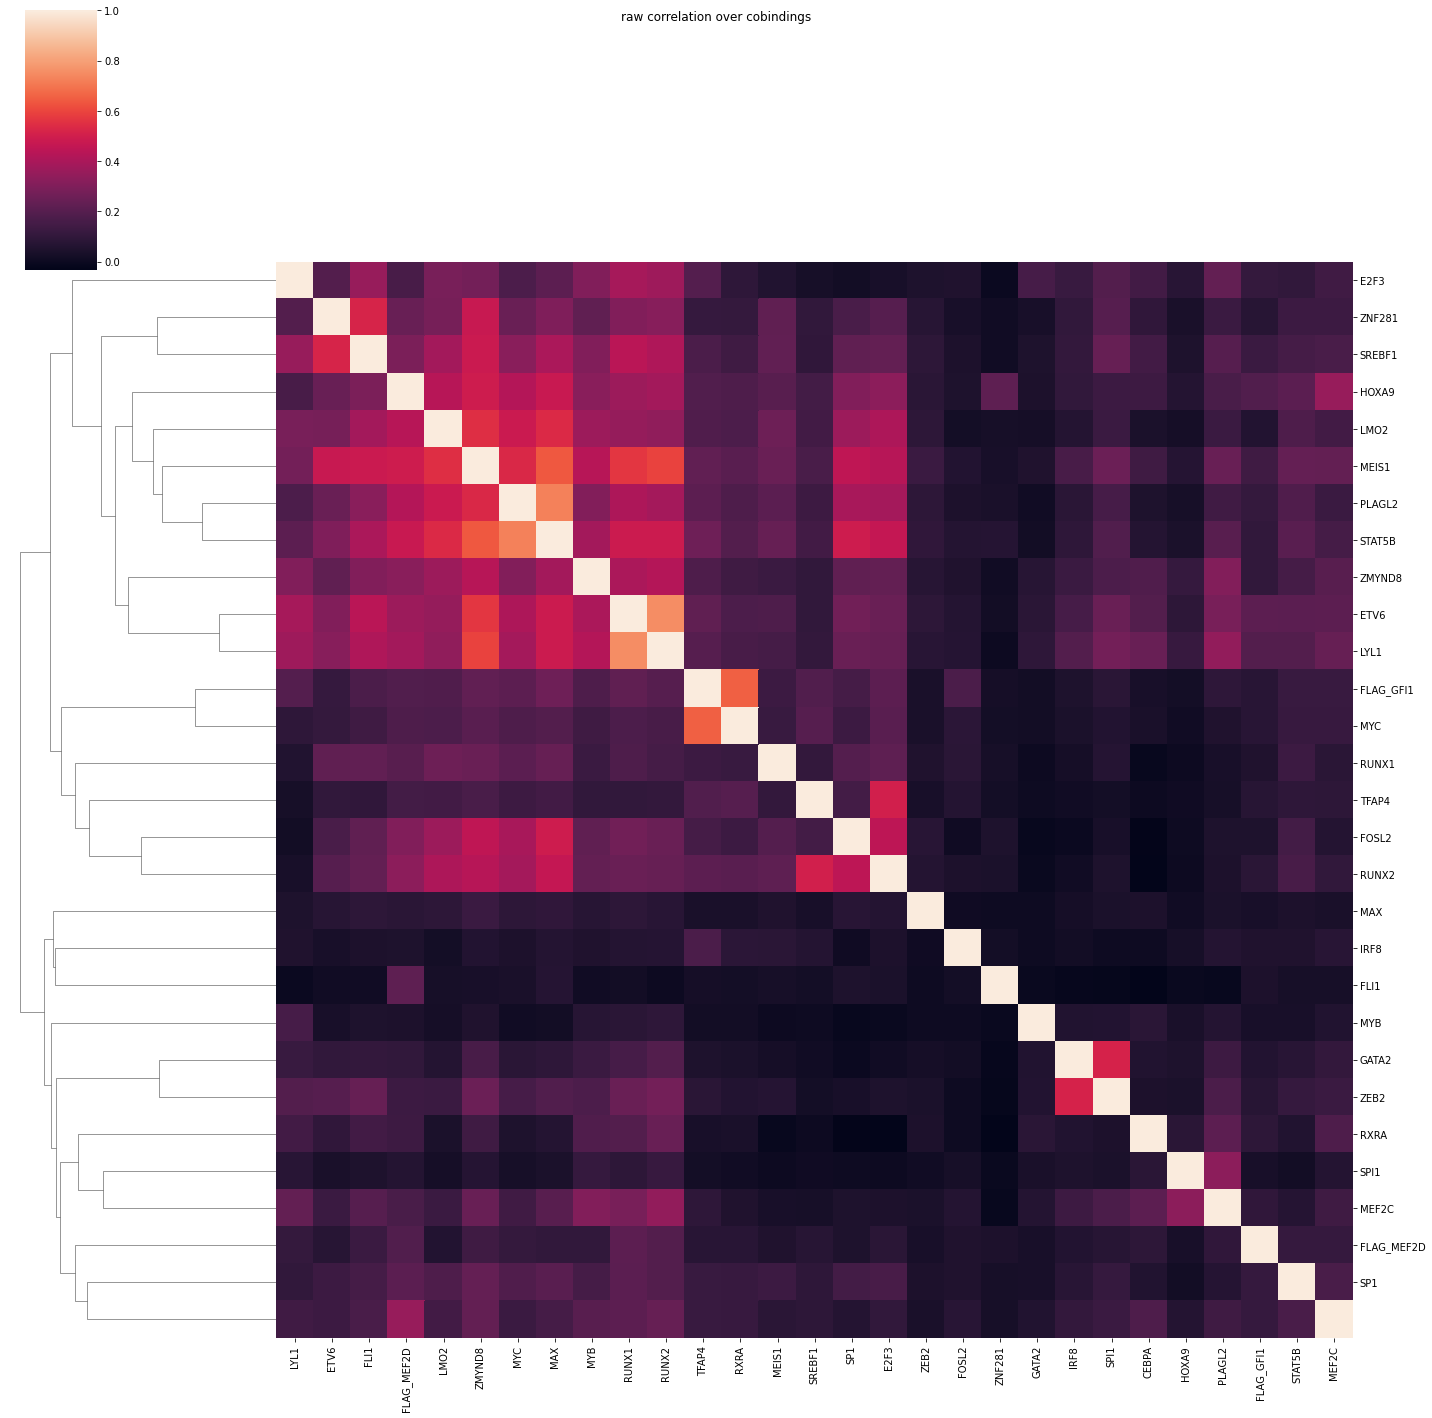

In [978]:
#raw correlation over cobindings
fig = sns.clustermap(np.corrcoef(stats.zscore(merged[set(merged.columns[cols:])].values.T, axis=1)), figsize=(20, 20), xticklabels=merged.columns[cols:], yticklabels=set(merged.columns[cols:])-set(['CEBPA']))
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("raw correlation over cobindings")
fig.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_correlation_cobinding_regular.pdf")

In [769]:
#for plotting the cobinding we are only looking at a random subset (~0.3%)
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)

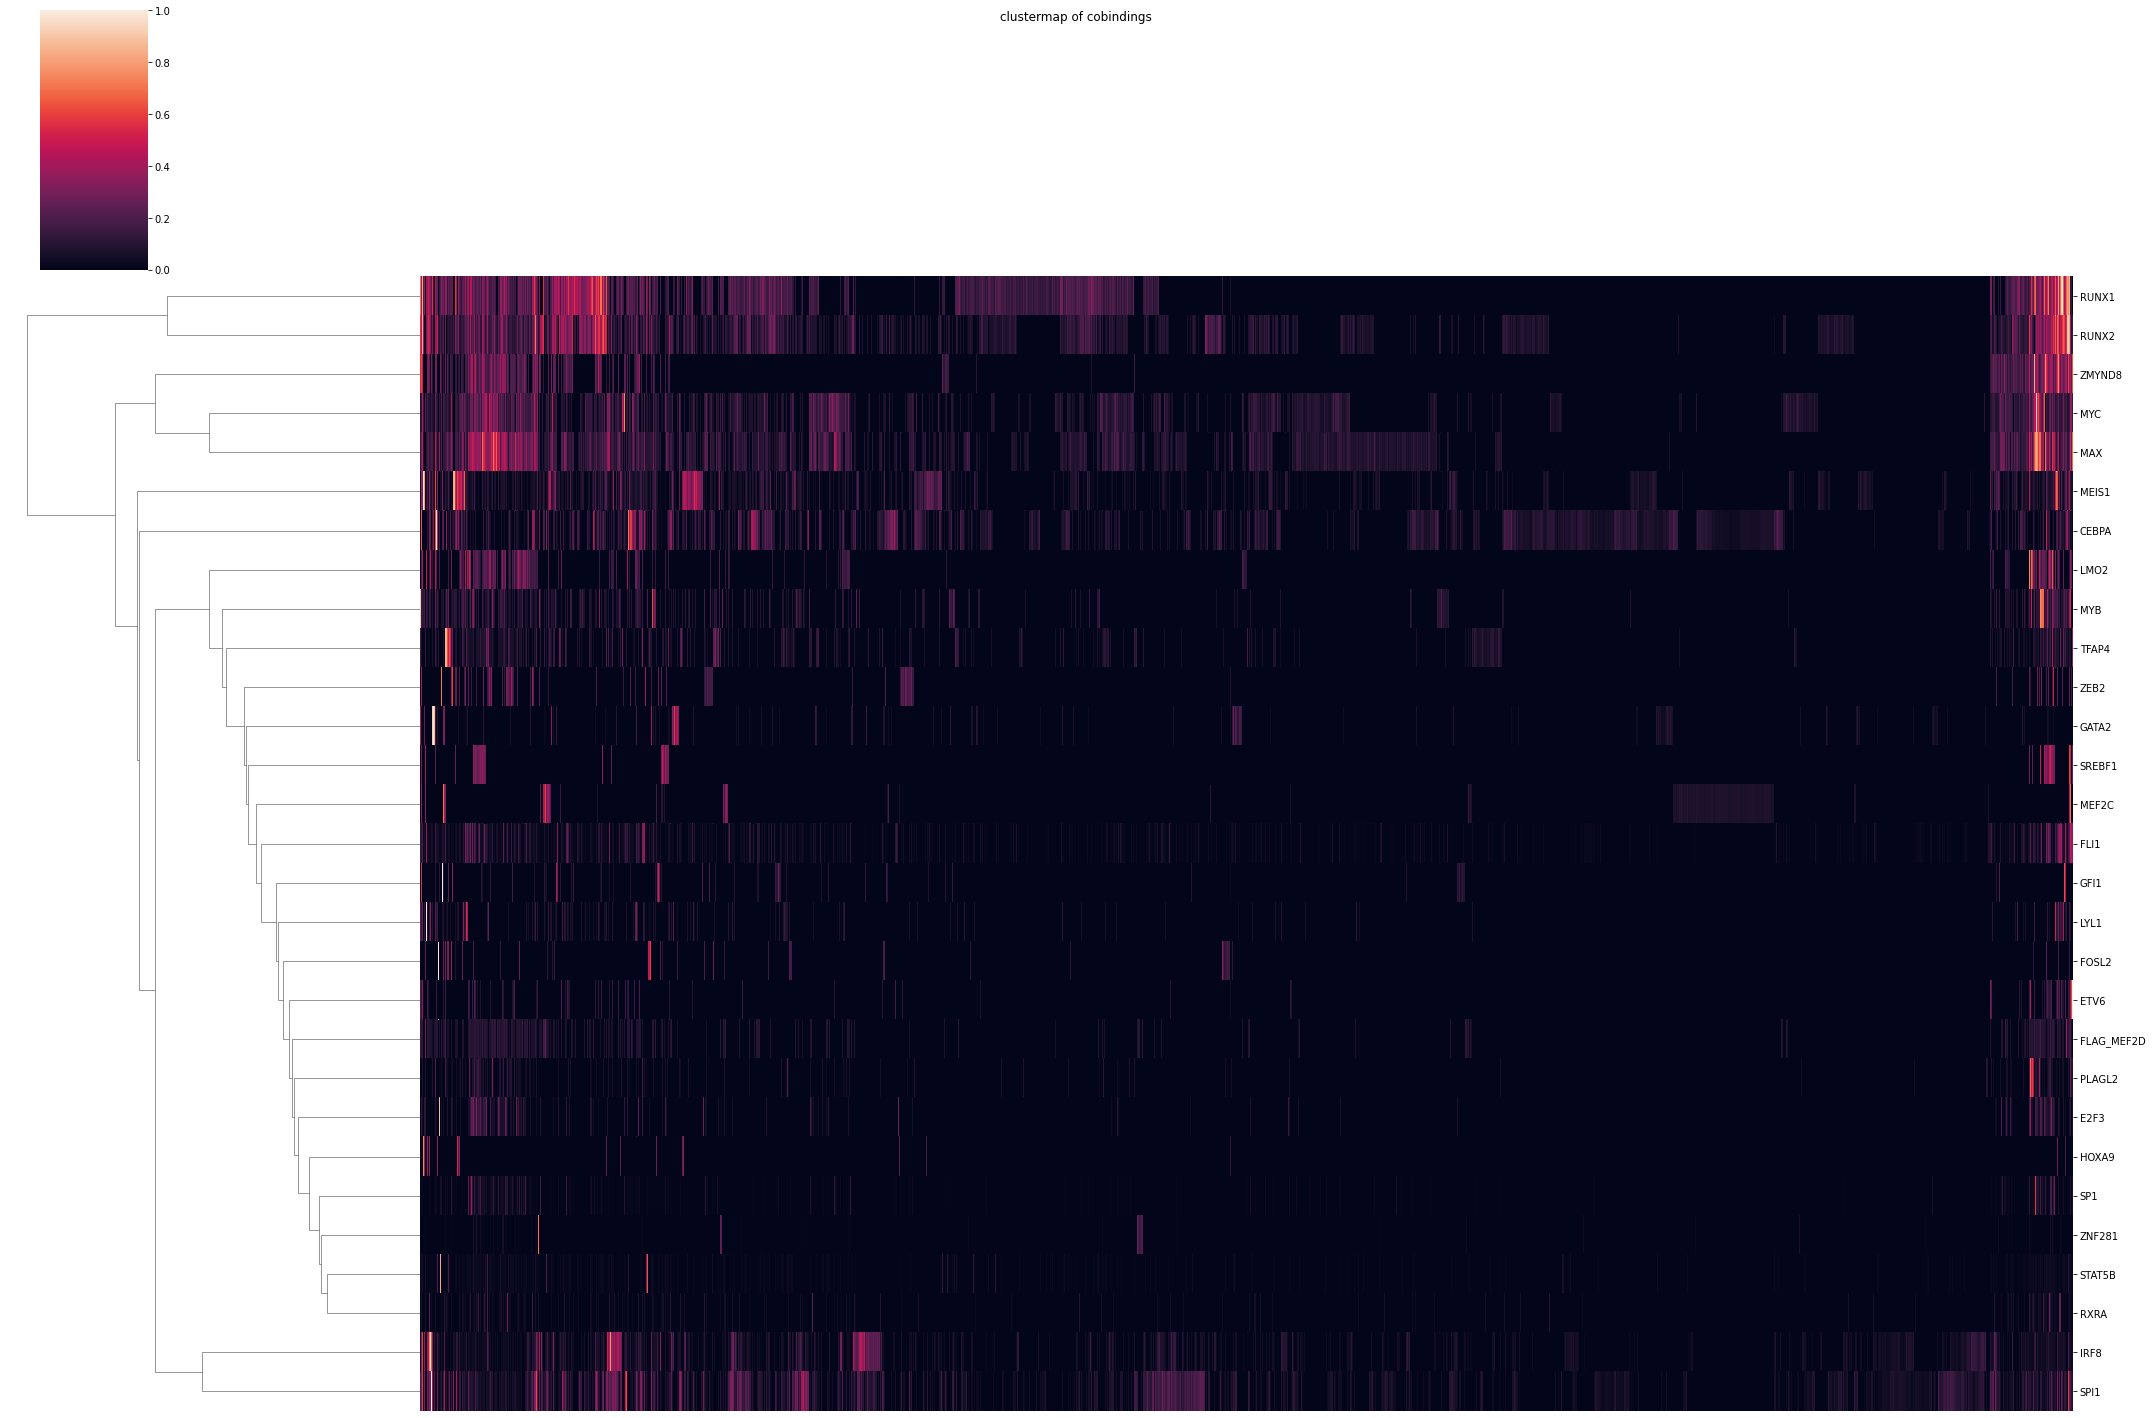

In [770]:
#clustermap of cobindings
fig = sns.clustermap(merged[merged.columns[cols:]].loc[rand].T, standard_scale=0, figsize=(30,20),xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled.pdf')
plt.show()

## Peak annotations

In [771]:
#list of additional chips not directly used in our cobinding matrix (used for annotations)
set(mergedpeak.tf) - set(merged.columns) 

{'AFF4',
 'BRD4',
 'CDK13',
 'CDK9',
 'CEBPB',
 'CTCF',
 'ELF2',
 'FLAG_GFI1',
 'FLAG_IRF2BP2',
 'FLAG_MEF2C',
 'FLAG_SPI1',
 'FOXP1',
 'H3K27ac',
 'H3K27me3',
 'H3K36me2',
 'H3K36me3',
 'H3K4me1',
 'H3K4me3',
 'H3K79me2',
 'H3K9ac',
 'IKZF1',
 'IRF2BP2',
 'JUND',
 'LDB1',
 'MED1',
 'MEF2D',
 'MLL_KTM2A',
 'MYBL2',
 'POLII',
 'PSER2',
 'RARA',
 'SMC1',
 'WDR5'}

In [ ]:
additional = {}
# creating activation and repression histone signal
additional['activation'] = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin(["H3K27ac",'H3K79me2','H3K36me3','H3K4me3','H3K9ac','H3K4me1'])], window=10, mergedFold="max")
additional['repression'] = chip.simpleMergePeaks(mergedpeak[mergedpeak.tf.isin(['H3K27me3', 'H3K36me2'])], window=10, mergedFold="max")
# adding other additionals
for val in set(mergedpeak.tf) - (set(merged.columns) | set(remove)):
    # let's as well only use the flag version of IRF2BP2
    if val in drop: 
        continue
    additional[val] = mergedpeak[mergedpeak.tf==val]

### compute promoters

In [991]:
promoters = pd.read_csv('../data/'+project+'/compute_genes/human_epdnew_TeLy2.bed', sep='\t',header=None).rename(columns={0:'chrom',1:'start',2:'end',3:'name',5:'strand'}).drop(4,1)


In [993]:
merged5

,chrom,start,end,name,strand,foldchange
0,chr1,959255,959256,NOC2L,-,1
1,chr1,960632,960633,KLHL17,+,1
2,chr1,966481,966482,PLEKHN1,+,1
3,chr1,976680,976681,PERM1,-,1
4,chr1,1000096,1000097,HES4,-,1
...,...,...,...,...,...,...
16450,chrX,155612585,155612586,SPRY3,+,1
16451,chrX,155612951,155612952,TMLHE,-,1
16452,chrX,155881344,155881345,VAMP7,+,1
16453,chrY,18992818,18992819,CD24,-,1


In [992]:
promoters = pd.read_csv('../data/'+project+'/compute_genes/human_epdnew_TeLy2.bed', sep='\t',header=None).rename(columns={0:'chrom',1:'start',2:'end',3:'name',5:'strand'}).drop(4,1)
promoters['foldchange']=1
promoters['name']=[i[:-2] for i in promoters['name']]
additional['promoters'] = promoters

### adding super enhancers

In [ ]:
peaks = !ls ../../data/$project/MV411peak/*H3K27ac*
peaks

In [ ]:
# we need to load all H3K27ac's bam files
! mkdir ../../data/$project/bams/
! gsutil -m cp gs://amlproject/Chip/res/bwa/mergedLibrary/*MV411*H3K27ac* ../../data/$project/bams/
! gsutil cp gs://amlproject/Chip/res/bwa/mergedLibrary/mp99* ../../data/$project/bams/
bams = ! ls ../../data/$project/bams/*MV411*.bam
bais = ! ls ../../data/$project/bams/*MV411*.bai

In [ ]:
#calling ROSE
helper.createFoldersFor('../../data/'+project+'/ROSE/')
for i, peak in enumerate(peaks):
    if i < 2:
        continue
    chip.MakeSuperEnhancers(peak,
                             bamFile=bams[i],
                             baiFile=bais[i],
                             controlBam= bams[-1],
                             controlBai= bais[-1],
                             outdir ='../../../data/'+project+'/ROSE/',
                             rosePath="../src/ROSE/") #no cd -

In [ ]:
#merging them all as well into one superenhancer set
rose = chip.simpleMergePeaks(chip.ReadRoseSuperEnhancers("../../data/"+project+"/ROSE/"), window=1000).drop(columns=["relative_summit_pos","-log10pvalue","-log10qvalue"])
# we get only enhacers supported by at least 1/3rd of our chips (>1)
rose = rose[rose[rose.columns[5:]].astype(bool).sum(1)>1]
additional['super_enhancer'] = rose.sort_values(by =['chrom', 
                                                     'start', 'end']).reset_index(drop = True)

### adding ATACseq datta

In [ ]:
! gsutil cp gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_*.broadPeak ../../data/$project/MV411peak/

In [ ]:
atac = !ls ../../data/$project/MV411peak/ATAC_*
for i,v in enumerate(atac):
    a = chip.loadPeaks(v, isMacs=False)
    a = a[['chrom','start',"end","peak_number",'foldchange']]
    a['strand'] = '+'
    additional['ATAC' if len(atac)==1 else 'ATAC'+str(i)] = a 
    #TODO: merge multiple atacseqs
#creating a folder to save all marks for cchromHMM
helper.createFoldersFor("../results/"+project+"/"+version+'_'+merging_version+'_'+window+"_MV411Merged/")
a.to_csv('../results/'+project+"/"+version+'_'+merging_version+'_'+window+'_MV411Merged/ATAC.bed',index=False,sep='\t')

In [ ]:
# saving all marks
for i in set(mergedpeak.tf):
    a = mergedpeak[mergedpeak.tf==i][['chrom','start',"end",'peak_number',"foldchange"]]
    a['strand']='+'
    a.to_csv("../results/" + project + "/" + version + '_' + merging_version + '_' + window + "_MV411Merged/" + i + '.bed', sep='\t', index=False)

### Running and adding ChromHMM

In [ ]:
#list of interesting marks for ChromHMM
l = ["H3K27ac", "H3K27me3", "H3K36me3", "H3K4me1", "H3K4me3", "H3K9me3"]

In [ ]:
## computing CHROMHMM
#!mkdir ../results/chromHMM/
outdir = '../results/chromHMM/' + version + '_' + merging_version + '_' + window + '_2/'
data = pd.DataFrame([['MV411'] * len(l), l,["../results/" + project + "/" + version + '_' + merging_version + '_' + window + '_MV411Merged/' + i + '.bed' for i in l]]).T

chrombed = chip.runChromHMM(outdir, data, numstates=15, datatype = 'bed', chromHMMFolderpath="../src/ChromHMM/", control_bam_dir = None)['MV411']

In [ ]:
# state information
from IPython.display import Image, display
im = ! ls $out*.png
for val in im:
    display(Image(filename=val))

In [ ]:
#setting state colors for plots
statetocol={i: chrombed[chrombed['state']==i].iloc[0]['color'] for i in set(chrombed['state'])}
statetocol.update({0:'0,0,0'})
for i,v in statetocol.items():
    statetocol[i] = tuple([int(i)/256 for i in v.split(',')])

In [ ]:
#renaming the states (and some other marks)
rn = {'SMC1':'cohesin', 'MED1':'mediator', 'ATAC':'open regions','state_1':'acti_state', 'state_2':'elong_state', 'state_5':'start_state', 'state_6':'repres_state'}
annot = len(merged.columns)
annot

### merging 
merging everything from additionals into the cobinding matrix

In [ ]:
merged.columns[:annot+1]

In [ ]:
#chrombed['foldchange']= chrombed['state']
#merged['HMM_states'] = chip.putInBed(merged[merged.columns[:cols]], chrombed, window=1, mergetype='first')
for key, val in additional.items():
    if key in merged.columns:
        continue
    print(key)
    if len(val)>1 and key not in ['FLAG_MEF2C']:
        merged[key] = chip.putInBed(merged[merged.columns[:cols]],val)
merged = merged.replace(np.nan,0)

#### total size of the cobinding matrix on the DNA

In [ ]:
sum([v['end'] - v["start"] for k, v in merged.iterrows()])

In [ ]:
## making regular enhancers from otherr annotations
merged['regular_enhancer'] = (merged['activation'].astype(bool) & ~merged['super_enhancer'].astype(bool) & ~merged['promoters'].astype(bool)).astype(float)

In [ ]:
#setting each state as a separate annotation
for i in range(1,1+numstates):
    merged['state_'+str(i)] = (merged.HMM_states==i).astype(float)
merged = merged.drop(columns=['HMM_states'])
# renaming
merged = merged.rename(columns=rn)

In [ ]:
merged = merged.drop(columns="FLAG_MEF2C")

In [ ]:
merging_version="remove_single"
window="150"
version

In [ ]:
merged = merged[merged[merged.columns[cols:]].astype(bool).sum(1)>1].reset_index(drop=True)

In [ ]:
merged.to_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'_with_annotations.bed.gz', sep='\t',index=None)

In [ ]:
merged = pd.read_csv('../results/'+project+'/merged_'+version+'_'+merging_version+'_'+window+'_with_annotations.bed.gz', sep='\t')

## In depth look at the cobinding matrix

First looking at the Basic Information about each annotations: total number of peaks, max peak signel, mean peak signal, stdev of peak signals

In [928]:
# Showing Basic Information about each annotations
info = pd.concat([merged[merged.columns[cols:]].astype(bool).sum(0),
           merged[merged.columns[cols:]].max(),
           merged[merged.columns[cols:]].replace(0, np.NaN).mean(),
          merged[merged.columns[cols:]].replace(0, np.NaN).var()],axis=1).rename(columns={0:'sum',1:'max',2:'mean',3:'std'})
info.to_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'info.tsv')
info.iloc[:60]

,sum,max,mean,std
CEBPA,56524,123.662740,10.371736,60.990329
HOXA9,1264,36.844650,7.179492,11.735557
PLAGL2,13978,1424.570000,8.478562,277.488796
MEIS1,51650,99.050100,10.121474,101.924229
ETV6,6671,80.067433,9.824713,41.801551
FLAG_GFI1,22234,82.751400,5.985914,30.929234
RUNX1,51965,85.437050,8.414745,24.435953
FOSL2,4109,367.017000,10.657884,127.103514
FLI1,52978,512.890000,16.315432,442.142200
GATA2,10475,191.227000,17.097017,390.289926


In [929]:
info.iloc[60:]

,sum,max,mean,std
super_enhancer,9571,36.169492,6.172187,12.823486
promoters,10123,1.000000,1.000000,0.000000


In [997]:
merged[(merged['super_enhancer']!=0)&(merged['promoters']!=0)]

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,CEBPA,HOXA9,...,H3K36me2,PSER2,H3K36me3,H3K9ac,CDK13,H3K4me1,POLII,MED1,super_enhancer,promoters
123,chr1,1779814,1780701,232,14.949544,6.515100e+10,3.240921e+10,735,26.765132,0.0,...,0.000000,13.018800,0.0,11.11840,0.0,0.0,4.635765,3.892720,4.930649,1.0
366,chr1,6579415,6580622,775,10.465872,6.607924e+06,2.783761e+06,426,0.000000,0.0,...,4.160830,15.595000,0.0,10.43510,0.0,0.0,7.919063,3.725267,6.368186,1.0
371,chr1,6600642,6603771,783,10.276866,3.220044e+06,2.001542e+06,457,0.000000,0.0,...,2.833255,3.279160,0.0,11.43640,0.0,0.0,0.000000,5.104657,6.368186,1.0
534,chr1,8878435,8879188,1169,17.317530,5.995085e+03,4.709560e+03,231,0.000000,0.0,...,4.114840,16.410400,0.0,10.32660,0.0,0.0,0.000000,5.682963,5.953614,1.0
562,chr1,9068982,9070091,1214,12.882580,1.893623e+08,7.616434e+07,905,6.150857,0.0,...,0.000000,0.000000,0.0,8.01859,0.0,0.0,0.000000,4.468863,5.391679,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121357,chrX,119692028,119693409,327837,8.802705,1.510634e+04,1.092135e+04,277,5.628400,0.0,...,0.000000,4.318250,0.0,10.62180,0.0,0.0,5.649840,3.784075,8.314155,1.0
121385,chrX,120250442,120251720,327891,6.990717,1.735625e+05,9.309739e+04,186,0.000000,0.0,...,2.708850,3.851715,0.0,9.31569,0.0,0.0,0.000000,5.730045,19.344143,1.0
121790,chrX,149504734,149505367,329146,8.291052,2.507922e+05,2.166537e+05,342,6.877523,0.0,...,0.000000,7.766960,0.0,5.80576,0.0,0.0,9.594800,4.252560,8.972538,1.0
121916,chrX,153971641,153972107,329420,12.583193,1.572947e+05,3.359025e+04,855,0.000000,0.0,...,0.000000,5.118020,0.0,11.29510,0.0,0.0,0.000000,4.738647,36.169492,1.0


In [870]:
touse = ['activation', 'repression', 'FLAG_IRF2BP2', 'cohesin', 'H3K79me2', 'H3K27me3', 'H3K27ac','H3K4me3', 'FOXP1', 'MLL_KTM2A', 'RARA', 'IKZF1','H3K18', 'H3K36me2', 'H3K36me3', 'H3K9ac', 'H3K4me1', 'POLII', 'mediator', 'open regions', 'promoters', 'super_enhancer', 'regular_enhancer']

In [930]:
rand = np.random.choice(merged.index,5000)
viridis = cm.get_cmap('viridis', 256)

data = merged[merged.columns[annot:]]
ma = data.max()
mi = data.min()
data = data.loc[rand]
data = (data-mi)/(ma-mi)
for val in data.columns:
    a = [viridis(int(v*256)) for v in data[val]]
    data[val] = a

### cobinding matrix

A matrix computed from overlapping binding profiles of TFs composing the CRC (bottom / red color). any peak around  window of X (150bp) to another get merged into a single, longer peak that has both TFs. Under this new set of peaks, we are looking for peaks from other proteins and histone marks (top / blue colors). This new addition won't change the matrix itself.

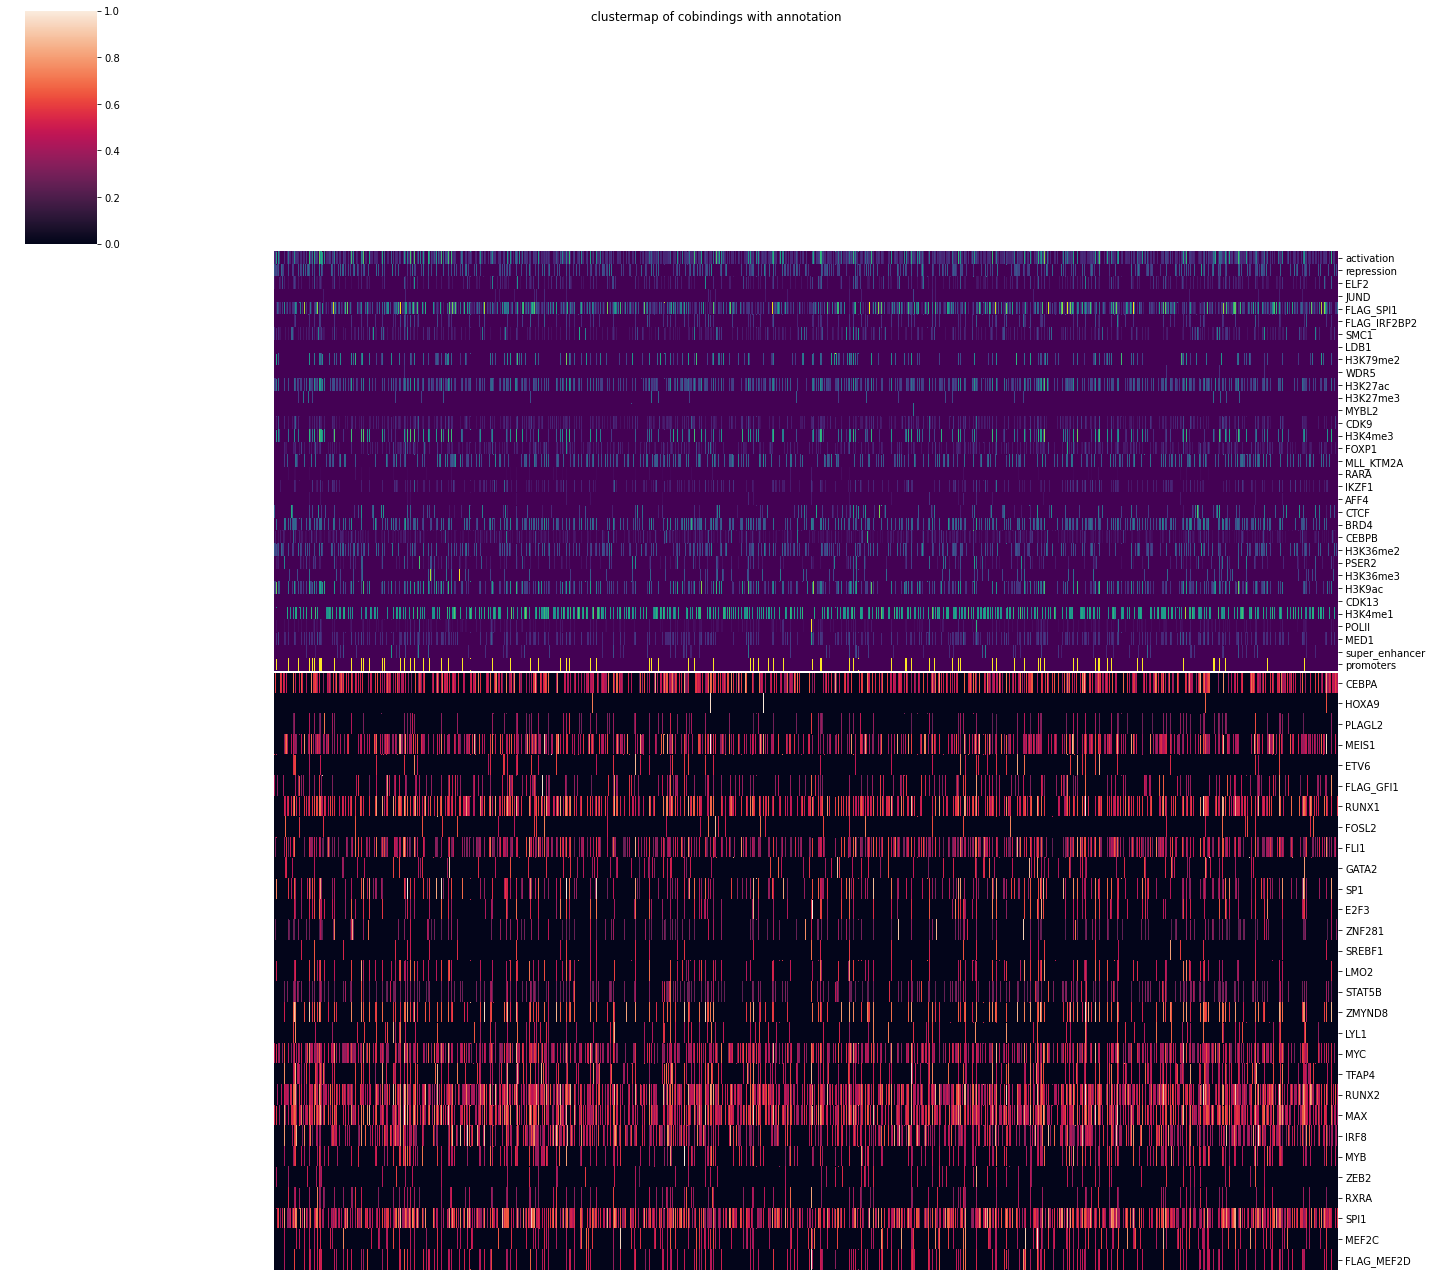

In [931]:
#clustermap of cobindings with annotation
fig = sns.clustermap(np.log2(1.01+merged[merged.columns[cols:annot]].loc[rand].T), standard_scale=0, colors_ratio=0.01, figsize=(20,18), col_colors = data, xticklabels=False, row_cluster=False, col_cluster=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("clustermap of cobindings with annotation")

fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled_full_annotations.pdf')
plt.show()

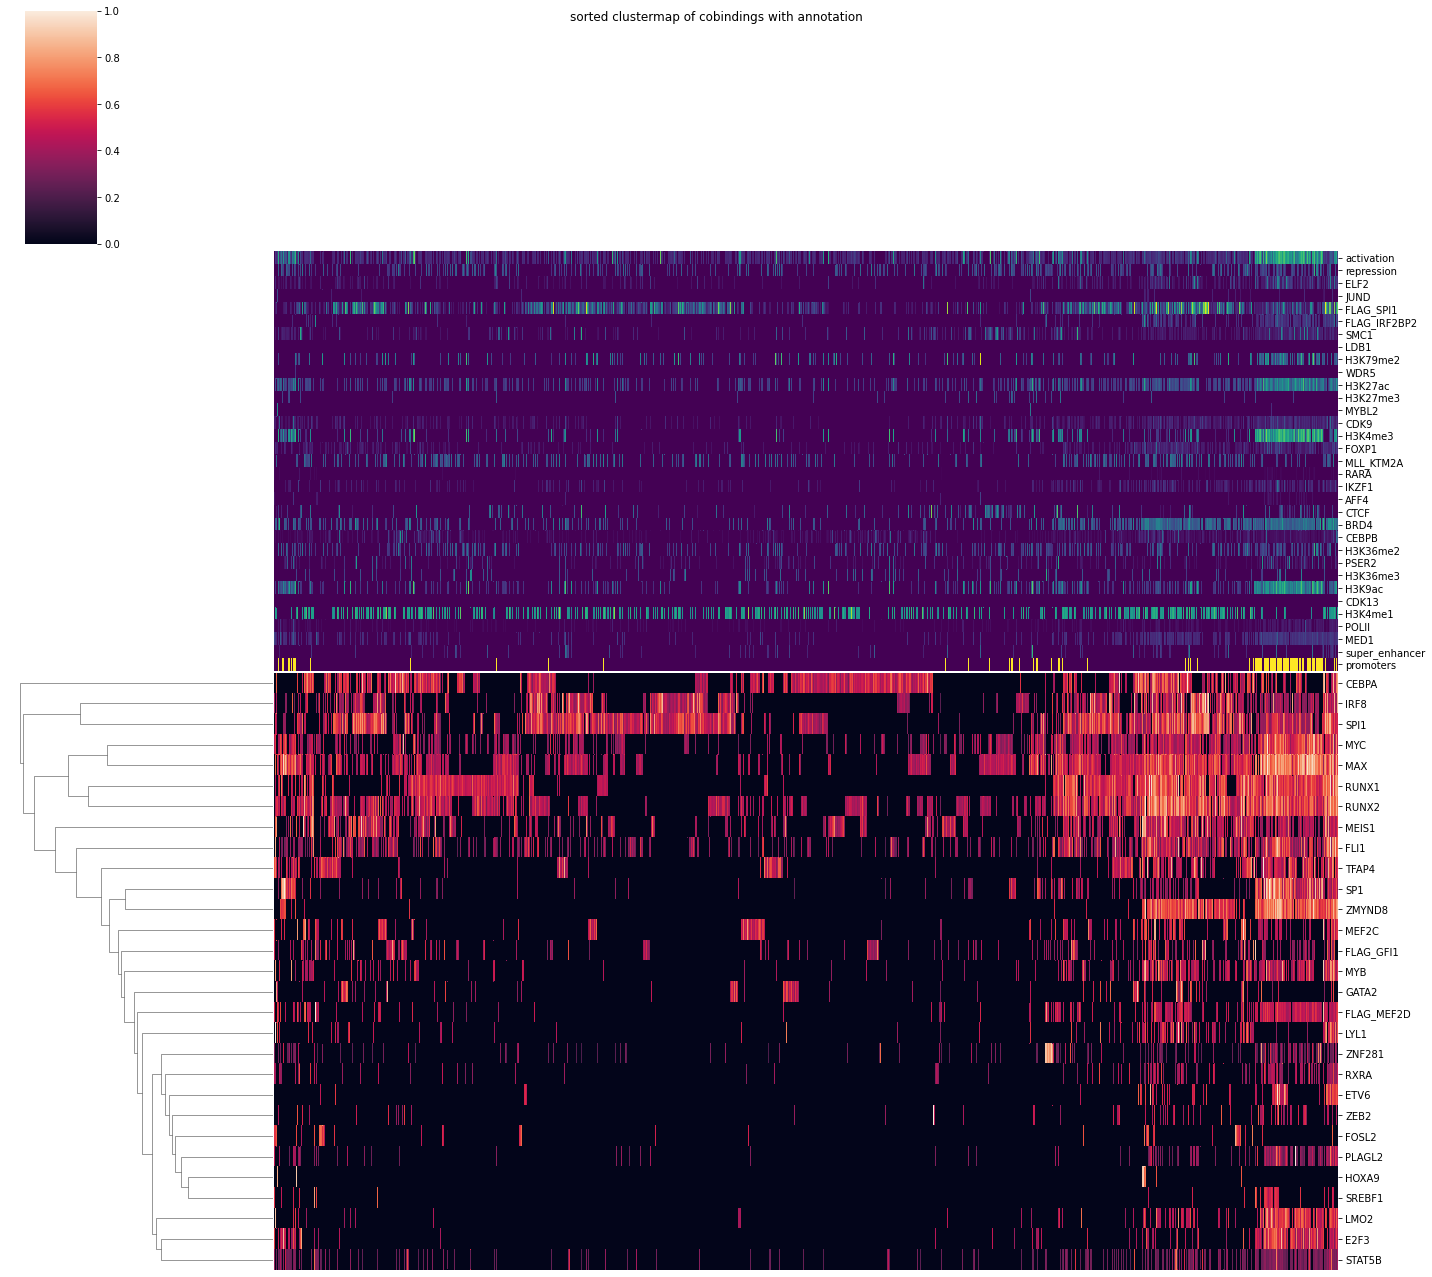

In [932]:
#sorted clustermap of cobindings with annotation
fig = sns.clustermap(np.log2(1.01+merged[merged.columns[cols:annot]].loc[rand].T), vmin=0, vmax=1, figsize=(20,18), colors_ratio=0.01, standard_scale=0, col_colors=data, xticklabels=False)
fig.ax_col_dendrogram.set_visible(False)
fig.fig.suptitle("sorted clustermap of cobindings with annotation")
fig.savefig('../results/'+project+'/plots/'+version+'_'+merging_version+'_'+window+'_clustermap_cobinding_scaled_full_annotation_sorted.pdf')
plt.show()

### TSNE of CRC binding profile

A 2D plot showing the similarity of different transcription factors. Plot using TSNE where similarity is represented by local distances. the similarity is computed on peak signal for each TF across the cobinding matrix. 

In [980]:
#scatter plot of distance of TF in cobinding space
red = TSNE(2,3).fit_transform(PCA(10).fit_transform(stats.zscore(merged[merged.columns[cols:annot]]).T))
pd.DataFrame(index=merged.columns[cols:annot],data=red, columns=['x','y']).to_csv("../results/"+project+'/'+version+"_"+window+"_"+merging_version+"_tsne_coordinates_crc_only.csv")
plot.scatter(red, radi=10, labels=merged.columns[cols:annot], showlabels=True, title="scatter plot of distance of TF in cobinding space", folder="../results/"+project+'/plots/'+version+"_"+window+"_"+merging_version+"_")

Figure(id='26285', ...)

In [935]:
merged.columns[cols:]

Index(['CEBPA', 'HOXA9', 'PLAGL2', 'MEIS1', 'ETV6', 'FLAG_GFI1', 'RUNX1',
       'FOSL2', 'FLI1', 'GATA2', 'SP1', 'E2F3', 'ZNF281', 'SREBF1', 'LMO2',
       'STAT5B', 'ZMYND8', 'LYL1', 'MYC', 'TFAP4', 'RUNX2', 'MAX', 'IRF8',
       'MYB', 'ZEB2', 'RXRA', 'SPI1', 'MEF2C', 'FLAG_MEF2D', 'activation',
       'repression', 'ELF2', 'JUND', 'FLAG_SPI1', 'FLAG_IRF2BP2', 'SMC1',
       'LDB1', 'H3K79me2', 'WDR5', 'H3K27ac', 'H3K27me3', 'MYBL2', 'CDK9',
       'H3K4me3', 'FOXP1', 'MLL_KTM2A', 'RARA', 'IKZF1', 'AFF4', 'CTCF',
       'BRD4', 'CEBPB', 'H3K36me2', 'PSER2', 'H3K36me3', 'H3K9ac', 'CDK13',
       'H3K4me1', 'POLII', 'MED1', 'super_enhancer', 'promoters'],
      dtype='object')

### TSNE of TF binding profile

A 2D plot showing the similarity of different transcription factors. Plot using TSNE where similarity is represented by local distances. the similarity is computed on peak signal for each TF across the cobinding matrix. 

In [990]:
#scatter plot of distance of TF in cobinding space
red = TSNE(2,6).fit_transform(stats.zscore(merged[merged.columns[cols:]]).T)
pd.DataFrame(index=merged.columns[cols:],data=red, columns=['x','y']).to_csv("../results/"+project+'/'+version+"_"+window+"_"+merging_version+"_tsne_coordinates_crc_only.csv")
plot.scatter(red, radi=5, labels=merged.columns[cols:], colors=[1 if val in crc else 0 for val in merged.columns[cols:]], showlabels=True, title="scatter plot of distance of TF in cobinding space", folder="../results/"+project+'/plots/'+version+"_"+window+"_"+merging_version+"_")

Figure(id='30190', ...)

In [938]:
%store merged
%store merging_version

Stored 'merged' (DataFrame)
Stored 'merging_version' (str)


## Comparison to a random distribution 

### computation:

we are evalutating each event's probability 1 binding, 2 binding, n binding.., as a binomial over the amount of proability p_i with n retries corresponding to the size of the conscensus peak set.
the probability p_i of this binomial is the sum of probabilities of having tf a binding with b for all possible combination of tf. 
the number of combination is k amongst n, n being 33, k going from 1 to 29
we compute 

$p(a & b) = p(a)\*p(b) =p(ab)$

and 

$p(a & b) | p(a & c) = p(ab) + p(ac) - p(abc)$

for a,b,c,d:

$p(ab) + p(ac) + p(ad) + p(bc) + p(bd) + p(cd) - {3\choose 2}*(p(abc) - p(abd) - p(bcd) - p(acd)) - {4\choose 2}*p(abcd)$

now we will be making the expected distribution

In [889]:
proba = (merged[merged.columns[cols:annot]].astype(bool).sum(0)/len(merged)).tolist()
size= len(proba)+1
sums = helper.makeCombinations(size, proba)

29
40920
28
237336
27
1107568
26
4272048
25
13884156
24
38567100
23
92561040
22
193536720
21
354817320
20
573166440
19
818809200
18
1037158320
17
1166803110
16
1166803110
15
1037158320
14
818809200
13
573166440
12
354817320
11
193536720
10
92561040
9
38567100
8
13884156
7
4272048
6
1107568
5
237336
4
40920
3
5456
2
528
1
33


In [890]:
# we are saving the expected distributions (as it is long to compute)
version = "v3"
merging_version = "simpleMerge"
window = "150"
a = '../results/' + project + '/*_sums.json'
!ls $a

../results/Cobinding_ChIP/v2_simpleMerge_150_sums.json
../results/Cobinding_ChIP/v3_remove_single_150_sums.json


In [891]:
helper.dictToFile(sums,'../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'_sums.json')

In [ ]:
sums = helper.fileToDict('../results/' + project + '/' + version + '_' + merging_version +  '_' + window+'_sums.json')
s={} 
for k,v in sums.items():
    s[int(k)] = sums[k]
sums = s
sums

In [ ]:
# computing the ratio to expected distribution
for i in range(len(sums)-1,0,-1):
    print(i,stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i]))
    sums[i] = [stats.binom.mean(len(merged), sums[i]),stats.binom.var(len(merged), sums[i])]

### distribution of cobindings

Barplot of the distribution of co-occurrences of peaks across the cobinding matrix

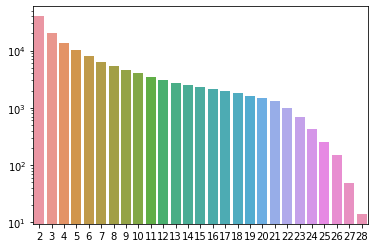

In [888]:
#we are looking at the distribution of pseudo-enhancers per cobound regions
counts,val = np.unique(merged[merged.columns[cols:annot]].astype(bool).sum(1).values, return_counts=True)
fig = sns.barplot(data=pd.DataFrame(val, index=counts,columns=['counts']).T)
fig.set_yscale("log")
fig.figure.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_distribution.pdf")

plotting the ratios

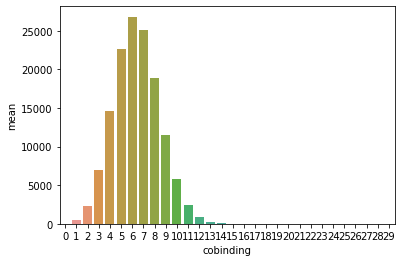

In [941]:
cobind = pd.DataFrame(sums).T.rename(columns={0:'mean',1:'var'})
cobind['cobinding']=cobind.index
fig = sns.barplot("cobinding","mean", data=cobind, ci=None)
#plt.errorbar(x=range(0,len(cobind)),y=cobind['mean'],
            #yerr=cobind['var'], fmt='none', c= 'r')
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_expected_cobinding_distribution.pdf")

Let's look at the enrichment of our current dataset

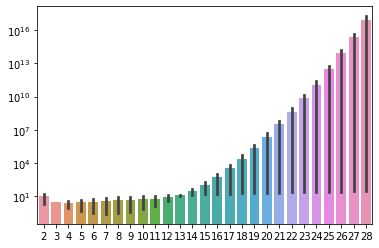

In [894]:
res = pd.DataFrame()
res['change']=val/cobind[cobind.cobinding.isin(counts)]['mean']
res['count']=list(res.index)
fig = sns.barplot(data=res.T).set_yscale("log")
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_enrichment.pdf")

### cobinding enrichment

Barplot (total + zoomed) of the enrichment in number of cobound proteins to a conscensus peak. This enrichment is computed from the expected distribution of cobindings given by the frequencies of peaks for each proteins, over the cobinding matrix. Cobound proteins are defined from called peaks, using macs2 on chipseq data.

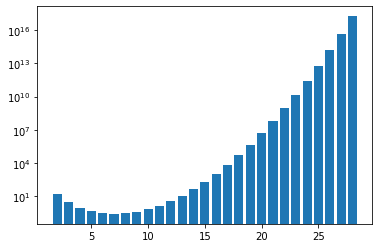

In [895]:
fig = plt.bar(res['count'],res['change'],log=True)
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window + "_cobinding_enrichment_matplotlib.pdf")
plt.show()

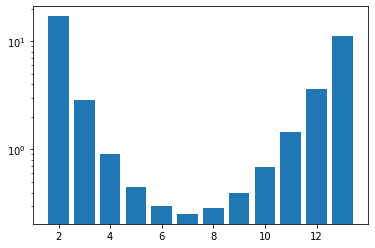

In [896]:
m =12
fig = plt.bar(res.iloc[:m]['count'],res.iloc[:m]['change'],log=True)
plt.savefig("../results/"+project+'/plots/'+version+'_'+merging_version+'_'+window+"_cobinding_enrichment_zoomed.pdf")
plt.show()

## Saving

In [887]:
%store chrombed
%store mergedpeak
%store cols
%store annot
%store version
%store window
%store crc

Stored 'merged' (DataFrame)
Stored 'chrombed' (DataFrame)
Stored 'mergedpeak' (DataFrame)
Stored 'cols' (int)
Stored 'annot' (int)
Stored 'version' (str)
Stored 'merging_version' (str)
Stored 'window' (str)
